In [60]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [61]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
time_expector = TimeExpector()

In [62]:
batch_size = 1
nb_epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

test_run = True
if test_run:
    print('[WARNING] : This is test run.')

[WARNING] : This is test run.


In [63]:
# FIXME
my_laptop = True
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    if test_run:
        trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])
for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

pre-processing dataset: 703
pre-processing dataset: 703


In [64]:
def plot_one_batch(network):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l)

In [65]:
from scnn.default_configs import *


class MyConv3D(torch.nn.Module):
    IS_CONV = True
    IS_SPIKING = True
    HAS_PARAM = True

    def __init__(self, input_shape, input_channels, output_shape=None,
                 output_channels=1, kernel_size=3, dilation=1,
                 spike_fn=None, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD, recurrent=False,
                 lateral_connections=True,
                 eps=EPSILON, stride=(1, 1, 1), flatten_output=False):

        super(MyConv3D, self).__init__()

        self.kernel_size = np.array(kernel_size)
        self.dilation = np.array(dilation)
        self.stride = np.array(stride)
        self.input_channels = input_channels
        self.input_shape = input_shape

        self.output_channels = output_channels
        self.output_shape = output_shape if output_shape is not None else input_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.lateral_connections = lateral_connections
        self.eps = eps

        self.flatten_output = flatten_output

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((output_channels, input_channels, *kernel_size)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_channels, output_channels)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_channels), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

        # TODO : check this
        tau_mem = 10e-3
        tau_syn = 5e-3
        time_step = 1e-3
        self._alpha = float(np.exp(-time_step / tau_syn))
        self._beta = float(np.exp(-time_step / tau_mem))

    def get_trainable_parameters(self, lr):
        res = [
            {'params': self.w, 'lr': lr, "weight_decay": DEFAULT_WEIGHT_DECAY},
            {'params': self.b},
            {'params': self.beta},
        ]

        if self.recurrent:
            res.append({'params': self.v})
        return res

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[2]
        
        stride = tuple(self.stride)
        padding = tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
        conv_x = torch.nn.functional.conv3d(x, self.w, padding=padding,
                                            dilation=tuple(self.dilation),
                                            stride=stride)
        conv_x = conv_x[:, :, :, :self.output_shape[0], :self.output_shape[1]]

        mem = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)
        syn = torch.zeros((batch_size, self.output_channels, *self.output_shape), device=x.device, dtype=x.dtype)  # FIXME
        spk = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)

        spk_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)
        mem_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)

        if self.lateral_connections:
            d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
        b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

        norm = (self.w ** 2).sum((1, 2, 3, 4))

        for t in range(nb_steps):
            # spike term
            # mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            # spk = self.spike_fn(mthr)

            if self.lateral_connections:
                rst = torch.einsum("abcd,be ->aecd", spk, d)
            else:
                rst = spk#torch.einsum("abcd,b,b->abcd", spk, self.b, norm)

            input_ = conv_x[:, :, t, :, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("abcd,be->aecd", spk, self.v)

#             # TODO : check to see if this is actually works
#             new_syn = self._alpha * syn + input_
#             new_mem = self._beta * mem + syn - rst
#             mem = new_mem
#             syn = new_syn
            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
            mthr = mem - b
#             mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            spk = self.spike_fn(mthr)

            spk_rec[:, :, t, :, :] = spk
            mem_rec[:, :, t, :, :] = mem
            

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()

        if self.flatten_output:
            output = torch.transpose(spk_rec, 1, 2).contiguous()
            output = output.view(batch_size, nb_steps, self.output_channels * np.prod(self.output_shape))
        else:
            output = spk_rec

        return output

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / (self.input_channels * np.prod(self.kernel_size))))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean,
                                  std=self.w_init_std * np.sqrt(1. / self.output_channels))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)


In [76]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)

# network.add_dense(
#     input_shape=(64,64),
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_layer(MyConv3D, #conv3d(
    input_shape=(64,64),
    
    output_channels=128,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    
    w_init_mean=0.8,
    w_init_std=0.16
)

# network.add_pool2d(kernel_size=(4,4))

# network.add_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# #     lateral_connections=True
# )

network.add_readout(output_shape=12,
                    time_reduction="mean" # mean or max
)

# for i in range(3):
#     for j in range(3):
#         network.layers[1].w[0, 0, 0, i, j] = 1./3. if i == j else 0.


network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

In [67]:
# test_img = np.zeros((64,64))
# for i in range(3):
#     for j in range(3):
#         for _x in range(16):
#             for _y in range(16):
#                 x = _x + 20*i + 4
#                 y = _y + 20*j + 4
                
#                 if i == 0 and j == 0:
#                     test_img[x, y] = 1 if _x==_y else 0
#                 elif i == 0 and j == 1:
#                     test_img[x, y] = 1 if _y==8 else 0
#                 elif i == 0 and j == 2:
#                     test_img[x, y] = 1 if _y==16-_x else 0

#                 elif i == 1 and j == 0:
#                     test_img[x, y] = 1 if _x==8 else 0
#                 elif i == 1 and j == 1:
#                     test_img[x, y] = 1 if 6.9 < ((_y-7)**2.+(_x-7)**2.)**.5 < 8 else 0
#                 elif i == 1 and j == 2:
#                     test_img[x, y] = 1 if _x==8 else 0
                
#                 elif i == 2 and j == 0:
#                     test_img[x, y] = 1 if (_x*_y) % 2 == 0 else 0
#                 elif i == 2 and j == 1:
#                     test_img[x, y] = 1 if (_x+_y) % 2 == 0 else 0
#                 elif i == 2 and j == 2:
#                     test_img[x, y] = 1
                    
# plt.imshow(test_img)

In [68]:
# img_stream = np.zeros((1, 1, 60, 64, 64))
# for i in range(60):
#     img_stream[0, 0, i, :, :] = test_img

In [69]:
# x = img_stream
# if isinstance(x, np.ndarray):
#     x = torch.from_numpy(x)
# x = x.to(network.device, network.dtype)

# batch_size = x.shape[0]
# nb_steps = x.shape[2]

# stride = tuple(network.layers[1].stride)
# padding = tuple(np.ceil(((network.layers[1].kernel_size - 1) * network.layers[1].dilation) / 2).astype(int))
# conv_x = torch.nn.functional.conv3d(x, network.layers[1].w, padding=padding,
#                                     dilation=tuple(network.layers[1].dilation),
#                                     stride=stride)
# conv_x = conv_x[:, :, :, :network.layers[1].output_shape[0], :network.layers[1].output_shape[1]]

In [70]:
# mem = torch.zeros((batch_size, network.layers[1].output_channels, *network.layers[1].output_shape), dtype=x.dtype, device=x.device)
# syn = torch.zeros((batch_size, network.layers[1].output_channels, *network.layers[1].output_shape), device=x.device, dtype=x.dtype)  # FIXME
# spk = torch.zeros((batch_size, network.layers[1].output_channels, *network.layers[1].output_shape), dtype=x.dtype, device=x.device)

# spk_rec = torch.zeros((batch_size, network.layers[1].output_channels, nb_steps, *network.layers[1].output_shape), dtype=x.dtype, device=x.device)
# mem_rec = torch.zeros((batch_size, network.layers[1].output_channels, nb_steps, *network.layers[1].output_shape), dtype=x.dtype, device=x.device)

# b = network.layers[1].b.unsqueeze(1).unsqueeze(1).repeat((1, *network.layers[1].output_shape))
# norm = (network.layers[1].w ** 2).sum((1, 2, 3, 4))

In [71]:
# %matplotlib inline
# conv_x_clamped = conv_x

# for t in range(nb_steps):
#     rst = spk#torch.einsum("abcd,b,b->abcd", spk, network.layers[1].b, norm)
#     input_ = conv_x_clamped[:, :, t, :, :]

#     # TODO : check to see if this is actually works
# #     new_syn = self._alpha * syn + input_
# #     new_mem = self._beta * mem + syn - rst
# #     mem = new_mem
# #     syn = new_syn
#     mem = (mem - rst) * network.layers[1].beta + input_ * (1. - network.layers[1].beta)
# #     mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + network.layers[1].eps)) - b
#     mthr = mem - b
#     spk = network.layers[1].spike_fn(mthr)

#     spk_rec[:, :, t, :, :] = spk
#     mem_rec[:, :, t, :, :] = mem
    
#     mem_img = mem.detach().numpy()[0, 0, :, :]
#     spk_img = spk.detach().numpy()[0, 0, :, :]
    
#     if np.min(mem_img) < 0 or np.max(mem_img) > 1:
#         print('                               [WARNING]: mem range:', np.min(mem_img), np.max(mem_img))
#     if np.min(spk_img) < 0 or np.max(spk_img) > 1:
#         print('                               [WARNING]: spk range:', np.min(spk_img), np.max(spk_img))
    
#     fig = plt.figure()
#     a = fig.add_subplot(1, 2, 1)
#     imgplot = plt.imshow(mem_img, vmin=0, vmax=1)
#     a.set_title('mem (%d)' % t)
#     plt.colorbar()#ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
#     a = fig.add_subplot(1, 2, 2)
#     imgplot = plt.imshow(spk_img, vmin=0, vmax=1)
#     imgplot.set_clim(0.0, 0.7)
#     a.set_title('spk')
#     plt.colorbar()#ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
#     plt.show()

# network.layers[1].spk_rec_hist = spk_rec.detach().cpu().numpy()
# network.layers[1].mem_rec_hist = mem_rec.detach().cpu().numpy()

Layer 1: average number of spikes=0.0414


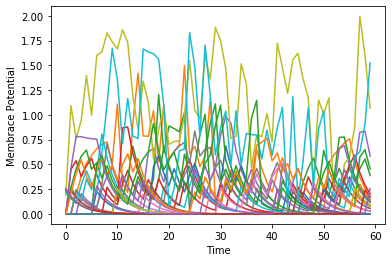

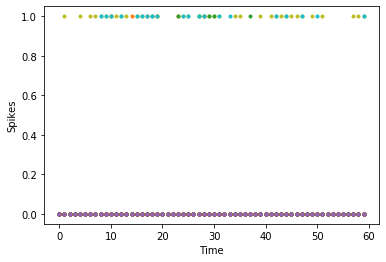

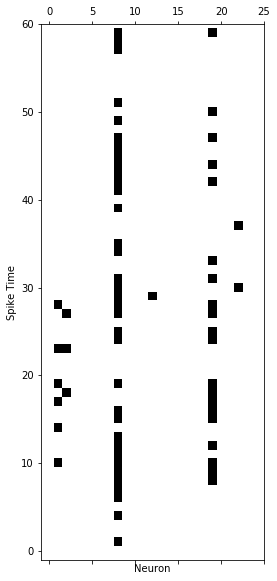

<Figure size 2160x1440 with 0 Axes>

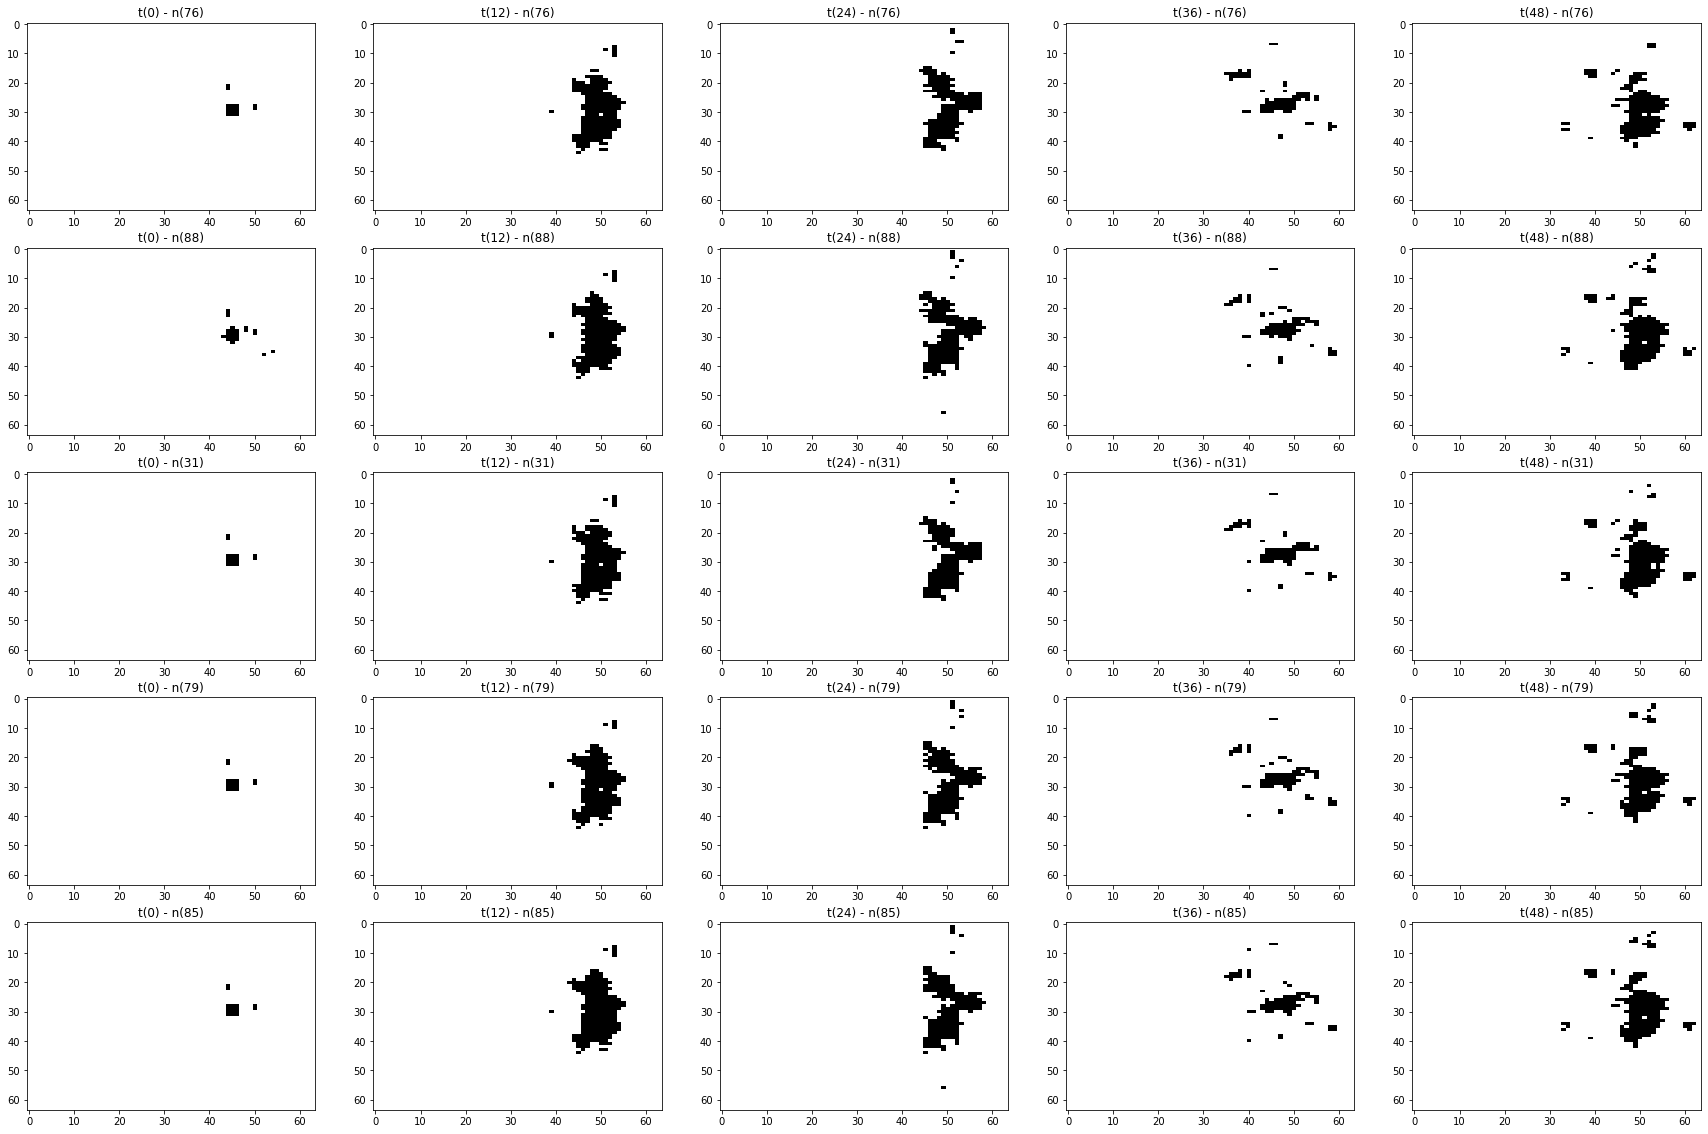

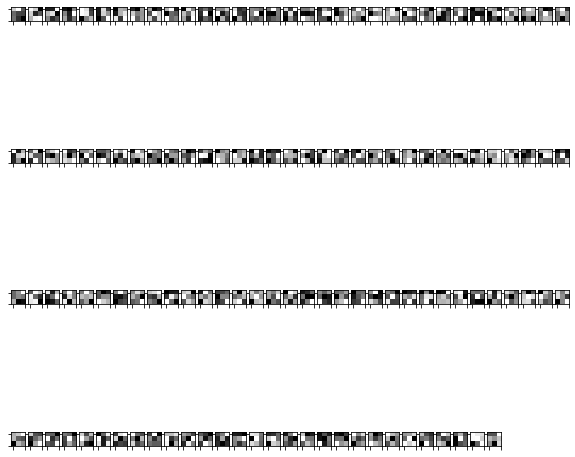

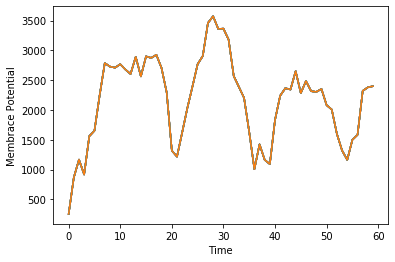

In [77]:
plot_one_batch(network)
# print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))

In [78]:
with open('results.log', 'w') as f:
    # opt = RAdam(network.get_trainable_parameters())
    lr=0.001
    opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=nb_epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f
    )
    plot_metrics(res_metrics)

network.save('save_network.net')
# network.load('save_network.net')


[WARNING] calling "tick" without a "tock"...
Epoch: 0 [>..........................................................] 1%     

KeyboardInterrupt: 

In [ ]:
plot_one_batch(network)
print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'))

In [ ]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)